# Imports

############ eosDD2 ###########
is_sorted(edens_new) False is_sorted(rho_new) False
rho limits: min:9.802e+01, max=1.464e+16


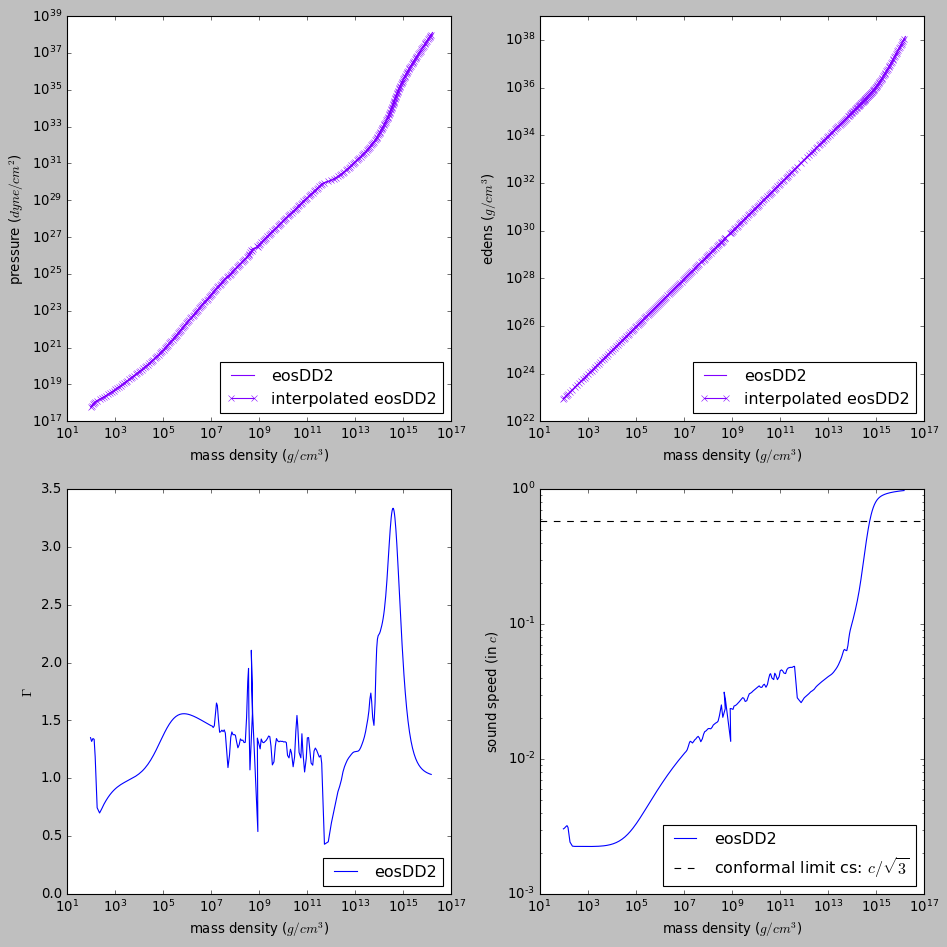

############ eosSLy ###########
is_sorted(edens_new) True is_sorted(rho_new) True
rho limits: min:1.591e+03, max=1.034e+16


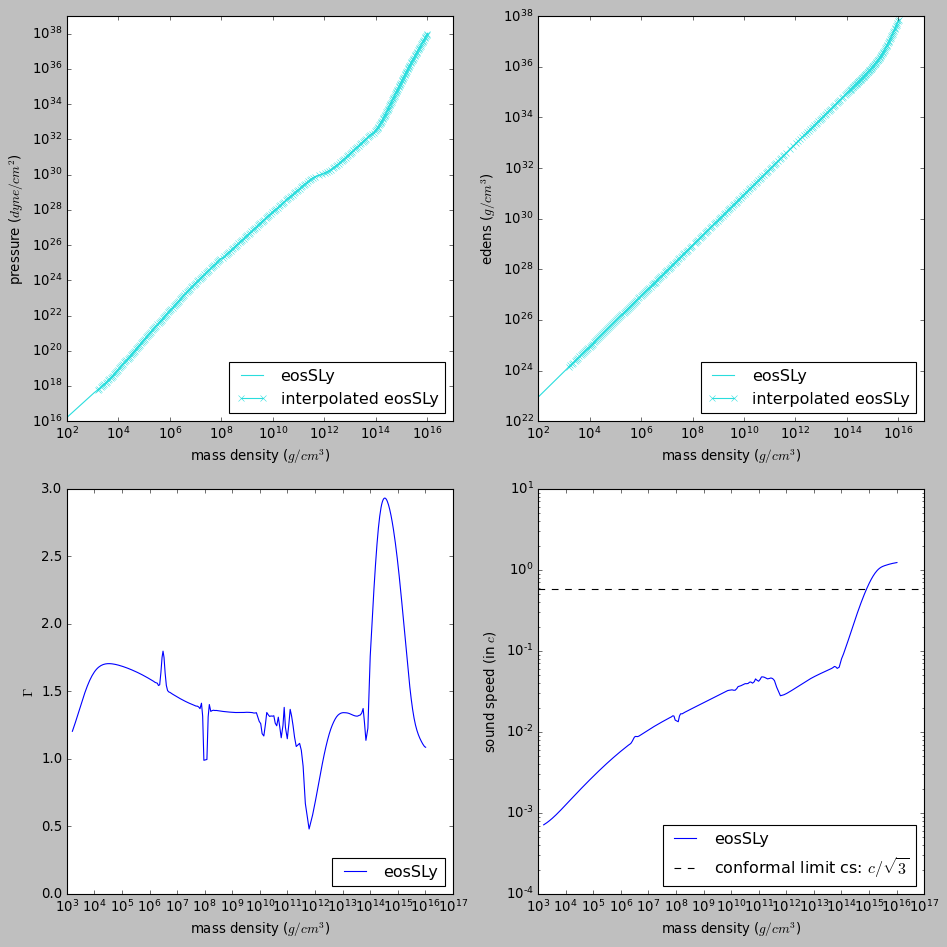

############ eosDD2 ###########
is_sorted(edens_new) False is_sorted(rho_new) False
rho limits: min:9.802e+01, max=1.464e+16


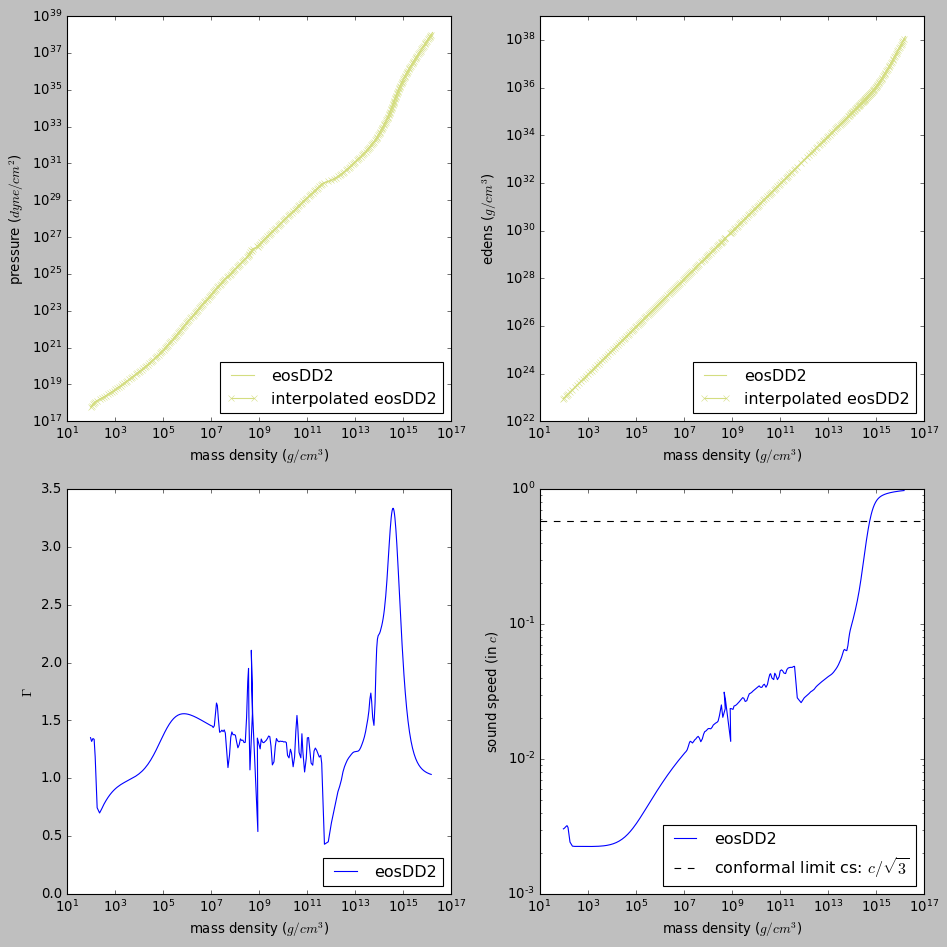

############ eos0 ###########
is_sorted(edens_new) True is_sorted(rho_new) True
rho limits: min:2.138e+02, max=7.353e+15


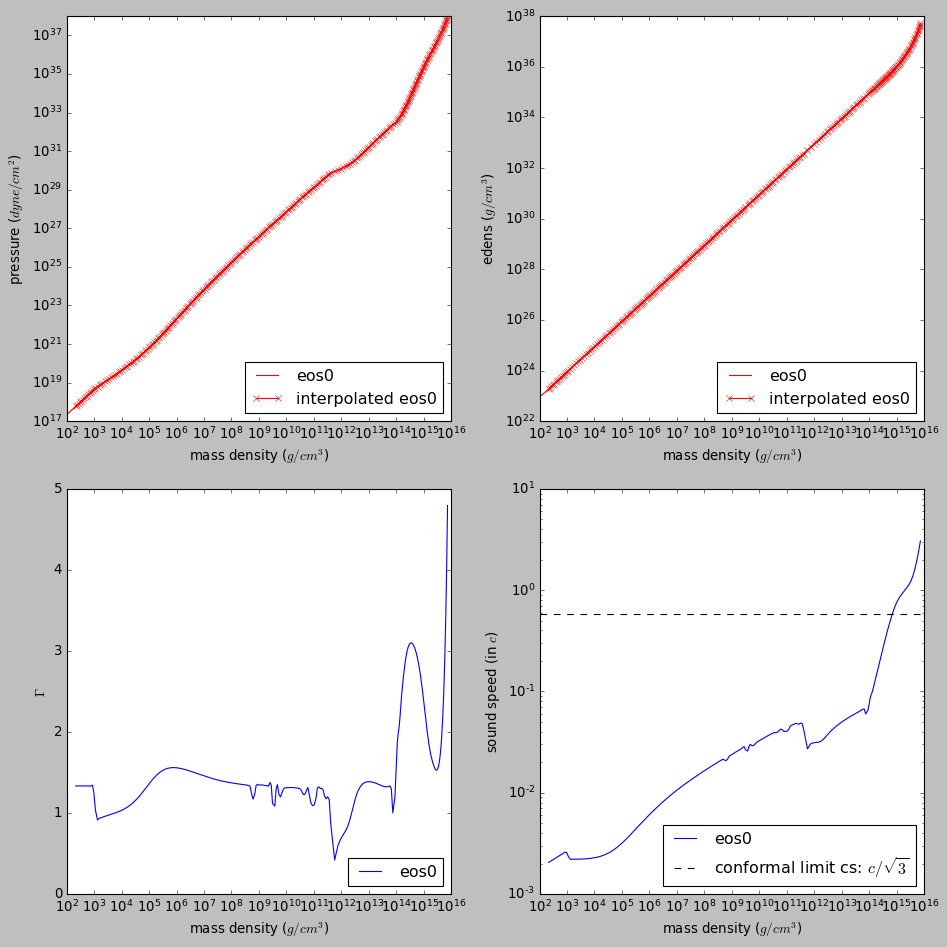

"key='BLQ'\nrho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene') #returns in cgs\nindex=np.array([int(i) for i in range(len(p_new))])\nnp.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_new/dens_conversion, edens_new/edens_conversion, p_new, gamma_new],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')\n\nkey='BLH'\nrho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLH_new_14-Apr-2020.lorene') #returns in cgs\nindex=np.array([int(i) for i in range(len(p_new))])\nnp.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_new/dens_conversion, edens_new/edens_conversion, p_new, gamma_new],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')\n"

In [2]:

import myconstants as const
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from matplotlib import rc
##from IPython.display import set_matplotlib_formats
##set_matplotlib_formats('svg')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
rc('axes', labelsize=20) #24
rc('legend', fontsize=18) #16
rc('xtick', labelsize=14)
rc('ytick', labelsize=14)

import time
from tovlib import *
from scipy.integrate import solve_ivp
#eos_file = './eos_tables/BLH_new_14-Apr-2020.lorene'
#eos_file = './eos_tables/SLy.lorene'


is_sorted = lambda x: (np.diff(x)>=0).all()

def eos_from_pres(pres_in,eos_file='./eos_tables/BLH_new_14-Apr-2020.lorene'):
    
    #if(pres_in.any()<0):
    #    print('pressure input is negative; stop integration and go to previous radial point')
    lg_pres_in = np.log10(pres_in)
    
    fm=1.e-13 #1femotometer in cm
    dens_conversion=const.CGS_AMU/(fm**3)
    edens_conversion=const.CGS_C**2
    
    ds=np.loadtxt(eos_file,comments='#',skiprows=9)
    #rho=ds[:,1]; edens=ds[:,2]; pres=ds[:,3]
    #print('all density > 0? ',all(i >= 0 for i in rho),'; all edens > 0? ',all(i >= 0 for i in edens),'; all pres > 0? ',all(i >= 0 for i in pres))
    #print('is_sorted(rho)? ',is_sorted(rho),'; is_sorted(edens)? ',is_sorted(edens),'; is_sorted(pres) ',is_sorted(pres))

    lg_rho, lg_edens, lg_pres = (np.log10(ds[:,1]),np.log10(ds[:,2]),np.log10(ds[:,3]))

    ind=lg_rho.argsort()                 # sorting mass and other array; necessary for interpolation routine
    sort_ind = ind[::1]
    lg_rho=lg_rho[sort_ind]
    lg_edens=lg_edens[sort_ind]
    lg_pres=lg_pres[sort_ind]
    
    
    #print(is_sorted(rho))
    #dp_dedens_arr=diff(pres)/diff(edens)/edens_conversion
    #dp_dedens_arr = np.insert(dp_dedens_arr, 0, dp_dedens_arr[0], axis=0)

    dlg_p_dlg_edens_arr=np.gradient(lg_pres,lg_edens) #https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
    gamma_arr = dlg_p_dlg_edens_arr
    Gamma_arr=((np.power(10,lg_edens)*edens_conversion+np.power(10,lg_pres))/(np.power(10,lg_edens)*edens_conversion)) * gamma_arr 
    
    rho_out=10**(splev(lg_pres_in,splrep(lg_pres,lg_rho,k=3,s=0)) )
    edens_out=10**(splev(lg_pres_in,splrep(lg_pres,lg_edens,k=3,s=0))) 
    Gamma_out=splev(lg_pres_in,splrep(lg_pres,gamma_arr,k=3,s=0))
    cs_out=np.sqrt((pres_in/edens_out)*(splev(lg_pres_in,splrep(lg_pres,gamma_arr,k=3,s=0))))  #sound speed: sqrt(dpres/dedens) = 
    #gamma_out=5./3.
    return rho_out*dens_conversion, edens_out, Gamma_out, cs_out


def eos_from_dens(rho_in,eos_file='./eos_tables/BLH_new_14-Apr-2020.lorene'):
    
    lg_rho_in = np.log10(rho_in)
    #print(lg_rho_in)
    fm=1.e-13 #1femotometer in cm
    dens_conversion=const.CGS_AMU/(fm**3)
    edens_conversion=const.CGS_C**2
    
    ds=np.loadtxt(eos_file,comments='#',skiprows=9)
    lg_rho, lg_edens, lg_pres = (np.log10(ds[:,1]*dens_conversion),np.log10(ds[:,2]),np.log10(ds[:,3]))
    #print(lg_rho)
    pres_out=10**(splev(lg_rho_in,splrep(lg_rho,lg_pres,k=3,s=0)) )
    edens_out=10**(splev(lg_rho_in,splrep(lg_rho,lg_edens,k=3,s=0))) 
    
    return pres_out, edens_out
###################################################################################3

fm=1.e-13 #1femotometer in cm
dens_conversion=const.CGS_AMU/(fm**3)
edens_conversion=const.CGS_C**2

eos_dir = './eos_tables/'
eos_list=['eosDD2','eosSLy','eosDD2','eos0']  #['eosSLy'] #,'eosDD2']
c_list=['r','b','c','k','g']
p_new=np.logspace(np.log10(6.e17),np.log10(1.e38),300)


n_end=4
colors = iter(cm.rainbow(np.linspace(0, 1,n_end )))  #len(eoslist)
for eoskey in eos_list:
    fig,((ax1,ax2),(ax3,ax4))=plt.subplots(nrows=2,ncols=2,figsize=(12,12))
    color=next(colors)
    print(f'############ {eoskey} ###########')
    eos_file = eos_dir+eoskey+'.lorene'
    eos_tabdata = np.loadtxt(eos_file,comments='#',skiprows=9)
    rho, edens, pres = (eos_tabdata[:,1],eos_tabdata[:,2],eos_tabdata[:,3])
    #print(eoskey,'\n####\n',rho,'\n#####\n',edens)
    #for p_in in p_new:
    rho_new, edens_new, gamma_new, cs_new = eos_from_pres(p_new,eos_file)
    
    print('is_sorted(edens_new)',is_sorted(edens_new),'is_sorted(rho_new)',is_sorted(rho_new))
    print(f'rho limits: min:{min(rho_new):1.3e}, max={max(rho_new):1.3e}')
    ax1.plot(rho*dens_conversion,pres,c=color,label=eoskey)
    ax1.plot(rho_new,p_new,c=color,marker='x',label='interpolated '+eoskey)
    #ax1.set_xlim([1.e14,1.e16])
    #ax1.set_ylim([1.e32,1.e36])
    ax1.set(xscale='log',yscale='log',xlabel=r'mass density ($g/cm^{3}$)',ylabel=r'pressure ($dyne/cm^2$)')
    ax1.legend(loc=4)

    ax2.plot(rho*dens_conversion,edens*edens_conversion,c=color,label=eoskey)
    ax2.plot(rho_new,edens_new*edens_conversion,c=color,marker='x',label='interpolated '+eoskey)
    #ax2.set_xlim([1.e14,1.e16])
    #ax2.set_ylim([1.e34,1.e37])
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set(xlabel=r'mass density ($g/cm^{3}$)',ylabel=r'edens ($g/cm^{3}$)')
    ax2.legend(loc=4)

    ax3.plot(rho_new,gamma_new,label=eoskey)
    ax3.set_xscale('log')
    ax3.set(xlabel=r'mass density ($g/cm^{3}$)',ylabel=r'$\Gamma$')
    ax3.legend(loc=4)
    
    ax4.plot(rho_new,cs_new/const.CGS_C,label=eoskey)
    ax4.set_xscale('log')
    ax4.set_yscale('log')
    ax4.set(xlabel=r'mass density ($g/cm^{3}$)',ylabel=r'sound speed (in $c$)')
    
    
    ax4.axhline(1/np.sqrt(3),ls='--',c='k',label='conformal limit cs: $c/\sqrt{3}$')
    ax4.legend(loc=4)
    plt.tight_layout()
    #plt.savefig('eos_plots_phase.png',dpi=150)

    plt.show()
    fig.clf()

## saving eos data in a file in a specific format -- 
"""key='BLQ'
rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene') #returns in cgs
index=np.array([int(i) for i in range(len(p_new))])
np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_new/dens_conversion, edens_new/edens_conversion, p_new, gamma_new],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')

key='BLH'
rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLH_new_14-Apr-2020.lorene') #returns in cgs
index=np.array([int(i) for i in range(len(p_new))])
np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_new/dens_conversion, edens_new/edens_conversion, p_new, gamma_new],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')
"""


In [3]:

## Root finding by reducing the radial interval and by using scipy.rootfind functions. 
## Works and matches with the MATLAB code.. although there are problems of (1) Speed and (2) accuracy 
from scipy import optimize
eos_file = './eos_tables/eos4.lorene'
#eos_file = './eos_tables/eos0.lorene'  #eosBHB


def calc_tidal_deformability(C, Y):
    # """ Compute the dimensionless tidal deformability parameter Lambda from the compactness C and 
    # the Lindblom y-potential at the surface of a polytropic star"""
    # Eq.(C1,C2) of Lindblom & Indik 2014
    zeta = 4. * C**3 * (13. - 11.*Y + C*(3.*Y-2.) + 2.*(C**2)*(1.+Y)) + 3. * ((1.-2.*C)**2) * (2. - Y + 2.*C*(Y-1.)) *np.log(1.-2.*C) + 2. * C * (6. - 3.*Y + 3.*C*(5.*Y-8.))
    Lambda_dimensionless = (16./(15.*zeta)) * ((1.-2.*C)**2) * (2. + 2.*C*(Y-1.) - Y)  #dimensionless tidal deformability
    #lambda_dimensional =   Lambda_dimensionless/const.CGS_G *(const.CGS_G*m*const.CGS_MSUN/const.CGS_C**2)**5
    return Lambda_dimensionless

def tov(r,y):

    [P, m, m_baryon, yp] = y
    #if(P<0):
    #    sys.exit()
    #if eos_file != None:
    #P,dummy = eos_from_dens(rhoc,eos_file)
    rho,eden,eos_gamma, cs = eos_from_pres(P,eos_file)

    G=const.CGS_G; c=const.CGS_C 

    dPdr = -G*(eden + P/c**2)*(m + 4.0*np.pi*r**3*P/c**2)
    dPdr = dPdr/(r*(r - 2.0*G*m/c**2))
    dmdr = 4.0*np.pi*r**2*eden
    dm_baryondr = dmdr/np.sqrt(1-2*G*m/(r*c**2))
    #G=cgs.G; c=cgs.c

    rho=eden*const.CGS_C**2
    dypdr= -yp**2/r -(r + (G/c**4)*4*np.pi*r**3*(P-rho))*yp/(r*(r-2*G*m/c**2)) + (G**2/c**4)*(4*(m+4*np.pi*r**3*P/c**2)**2)/(r*(r-2*G*m/c**2)**2) + 6/(r-2*const.CGS_G*m/const.CGS_C**2) - 4*np.pi*(r**2)*(5*rho+9*P+(rho+P)**2/(P*eos_gamma))*G/(c**4 * (r-2*G*m/c**2))

    return [dPdr, dmdr, dm_baryondr,dypdr]

def tovsolve(rhoc,r_arr):
    P,dummy = eos_from_dens(rhoc,eos_file)
    rho,eden,Gamma,cs = eos_from_pres(P,eos_file)
    
    rad_low = r_arr[0]; rad_high = r_arr[-1]
    print(rad_low,rad_high)
    
    rmin = r_arr[0]
    r3=rmin**3
    m = 4./3.*np.pi*r3*eden
    m_baryon = 4./3.*np.pi*r3*eden*(1-2*const.CGS_G*m/(rmin*const.CGS_C**2))**(-0.5)
    yp=2.
    #psol = odeint(tov, [P, m, m_baryon, yp], r_arr, rtol=1.0e-6, atol=1.0e-4,tfirst=True)

    psol = solve_ivp(tov, [rad_low, rad_high] ,[P, m, m_baryon, yp], method='RK45',t_eval=r_arr)
    #print m, m_baryon, rhoc
    #return r_arr, psol[:,0], psol[:,1], psol[:,2], psol[:,3]
    return psol.t, psol.y[0], psol.y[1], psol.y[2], psol.y[3] 


def find_surface(pmin, rhoc, rad_high):
    int_pts=10000
    rad_low=1.e-3
    r_arr = np.linspace(rad_low, rad_high,int_pts)
    #r = np.logspace(-4,6.3,N)

    #star = tovsolve(rhoc,r_arr)

    Pc,dummy = eos_from_dens(rhoc,eos_file)
    rhoc,eden_c,Gamma_c,cs_c = eos_from_pres(Pc,eos_file)
    #print(f'for pressure in: {Pc:1.2e}, density is {rhoc:1.2e}, edens: {eden_c:1.2e}, Gamma:{Gamma_c} and sound speed: {cs_c:1.2e}')
    rmin = r_arr[0]
    #print(f'rmin:{rmin:1.2e}')
    r3=rmin**3
    m = 4./3.*np.pi*r3*eden_c
    #print('g_00',np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2)))
    m_baryon = m/np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2))
    yp=2.
    
    var_vec=[Pc, m, m_baryon, yp]
    
    #psol = odeint(tov, var_vec, r_arr, rtol=1.0e-6, atol=1.0e-4,tfirst=True)
    #end_pres = psol[:,0][-1]
    #return end_pres-pmin

    psol = solve_ivp(tov, [rad_low, rad_high] ,var_vec, method='RK45')
    return psol.y[0][-1]-pmin
    ############################

    
    
    
###
time1=time.time()

#######################################################3
pmin=1.e-12
len_seq=5
rhoc_arr=np.logspace(np.log10(7.e14),np.log10(3.e15),len_seq)

tov_data=[]
for rhoc in rhoc_arr:
    #rhoc=4.e14 #cgs
    rstar = optimize.brentq(lambda rad_high: find_surface(pmin,rhoc,rad_high), 6.e5, 3.e6,rtol=1.e-4)
    #rstar = optimize.bisect(lambda rad_high: find_surface(pmin,rhoc,rad_high), 6.e5, 3.e6,rtol=1.e-5)
    
    #print(rstar/1.e5)

    time4= time.time()
    print('time elapsed in root finding:',time4-time1)

    rad_low = 1.e-3; rad_high = rstar
    int_pts=2000
    r_arr = np.linspace(rad_low, rad_high,int_pts)
    #r = np.logspace(-4,6.3,N)

    #star = tovsolve(rhoc,r_arr)

    Pc,dummy = eos_from_dens(rhoc,eos_file)
    rhoc,eden_c,Gamma_c,cs_c = eos_from_pres(Pc,eos_file)
    print(f'for pressure in: {Pc:1.2e}, density is {rhoc:1.2e}, edens: {eden_c:1.2e}, Gamma:{Gamma_c} and sound speed: {cs_c:1.2e}')
    rmin = r_arr[0]
    #print(f'rmin:{rmin:1.2e}')
    r3=rmin**3
    m = 4./3.*np.pi*r3*eden_c
    #print('g_00',np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2)))
    m_baryon = m/np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2))
    yp=2.
    psol = solve_ivp(tov, [rad_low, rad_high] ,[Pc, m, m_baryon, yp], method='RK45') #,t_eval=r_arr)
    [P, m, m_baryon, yp] = [psol.y[0][-1], psol.y[1][-1], psol.y[2][-1], psol.y[3][-1]]

    print(f'FINAL: rstar: {rstar/1.e5:1.2f}, grav. mass: {m/const.CGS_MSUN:1.2f}, bary. mass: {m_baryon/const.CGS_MSUN:1.2f}, yp: {yp}')
##
time2 = time.time()
print('time elapsed:',time2-time4)

"""
#######################################################
time2 = time.time()
#rhoc=3.e14 # cgs   

def get_tovStar(rhoc):
    rad_low=1.e-3
    rad_high=3.e6 
    int_pts=60
    r_arr = np.linspace(rad_low, rad_high,int_pts)
    
    Pc,dummy = eos_from_dens(rhoc,eos_file)
    rhoc,eden_c,Gamma_c,cs_c = eos_from_pres(Pc,eos_file)
    print(f'for central pressure: {Pc:1.2e}, density ={rhoc:1.2e}, edens = {eden_c:1.2e}, Gamma = {Gamma_c} and sound speed = {cs_c:1.2e}')
    rmin = r_arr[0]
    #print(f'rmin:{rmin:1.2e}')
    r3=rmin**3
    m = 4./3.*np.pi*r3*eden_c
    #print('g_00',np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2)))
    m_baryon = m/np.sqrt(1-2*const.CGS_G*m/(rmin*const.CGS_C**2))
    yp=2.
    y_new=[Pc, m, m_baryon, yp]
    pmin=1.e-12 #Pc*1.e-11
    print(f'minimum pressure to reach is = {pmin:1.2e}')

    eps_rad=1000 #cm
    dr=r_arr[1]-r_arr[0]
    
    eps_pres = 1.e-12; eps_mass = 1.e20; eps_yp = 1.e-6 
    for i,r in enumerate(r_arr):
        y_old = y_new
        tst_solvivp = time.time()
        psol = solve_ivp(tov, [r, r+dr] ,y_old, method='RK45',atol=[eps_pres,eps_mass,eps_mass,eps_yp],rtol=1.e-3)
        ten_solvivp = time.time()
        print(f'time per solve_ivp:{ten_solvivp-tst_solvivp}')
        [P, m, m_baryon, yp] = [psol.y[0][-1], psol.y[1][-1], psol.y[2][-1], psol.y[3][-1]]
        y_new = [P, m, m_baryon, yp]
        #print(f'NEW: pressure: {P:1.2e}, grav. mass: {m:1.2e}, bary. mass: {m_baryon:1.2e}, yp: {yp}')

        if(P<pmin):
            n=int(dr/eps_rad)
            #print(r,dr,n)
            rad_arr = np.linspace(r,r+dr,n)

            ddr = rad_arr[1]-rad_arr[0]
            y_new2 = y_old
            for r in rad_arr:
                y_old = y_new2
                tst_solvivp = time.time()
                psol = solve_ivp(tov, [r, r+ddr] ,y_old, method='RK45',atol=[eps_pres,eps_mass,eps_mass,eps_yp],rtol=1.e-3)
                ten_solvivp = time.time()
                print(f'time per solve_ivp (finer grid):{ten_solvivp-tst_solvivp}')
                [P, m, m_baryon, yp] = [psol.y[0][-1], psol.y[1][-1], psol.y[2][-1], psol.y[3][-1]]
                y_new2 = [P, m, m_baryon, yp]
                if(P<pmin):       
                    [P, m, m_baryon, yp] = y_old
                    #print(f'radius: {r/1.e5} km, mass: {m/const.CGS_MSUN} solar mass')
                    print(f'Final: pressure: {P:1.2e}, rhoc:{rhoc:1.2e} radius: {r/1.e5} km, grav. mass: {m/const.CGS_MSUN:1.2f}, bary. mass: {m_baryon/const.CGS_MSUN:1.2f}, yp: {yp}')
                    break
            
            break
            
        #else:
            #print(f'did not reach pmin={pmin:1.2e} for eos={eos_file}')
    C=(G/c**2)*m/r
    lambda_dimensionless = calc_tidal_deformability(C,yp)
    return C, m_baryon/const.CGS_MSUN, m/const.CGS_MSUN, r/1.e5, lambda_dimensionless


len_seq=5
rhoc_arr=np.logspace(np.log10(6.e14),np.log10(3.e15),len_seq)

tov_data=[]
for rhoc in rhoc_arr:
    C,mb,mg,r,lam = get_tovStar(rhoc) 
    tov_data.append([C,mb,mg,r,lam])


print(tov_data)



time3 = time.time()
print('time elapsed in loops:',time3-time2)
"""



################################################
"""for i,r in enumerate(r_arr):
    #print(f'iteration:{i}, radial coordinate: {r_arr[i]}')

    y_old = y_new
    #[P, m, m_baryon, yp] = y_old
    #print(f'OLD: pressure: {P:1.2e}, grav. mass: {m:1.2e}, bary. mass: {m_baryon:1.2e}, yp: {yp}')
    dr=r_arr[i+1]-r_arr[i]
    #print(f'dr: {dr:1.2e}')
    #print(tov(y,r))
    [dPdr, dmdr, dm_baryondr,dypdr] = tov(r,y_old)
    #print(f'dPdr:{dPdr:1.2e},dmdr:{dmdr:1.2e},dm_baryondr:{dm_baryondr:1.2e},dypdr:{dypdr:1.2e}')
    #print(dr*np.array([dPdr, dmdr, dm_baryondr,dypdr]))
    y_new=y_old+dr*np.array([dPdr, dmdr, dm_baryondr,dypdr])
    [P, m, m_baryon, yp] = y_new
    #print(f'NEW: pressure: {P:1.2e}, grav. mass: {m:1.2e}, bary. mass: {m_baryon:1.2e}, yp: {yp}')

    pmin=Pc*1.e-11
    if(P<pmin):
        print(f'radius: {r/1.e5} km, mass: {m/const.CGS_MSUN} solar mass')
        sys.exit()"""


/home/rkashyap/sw/anaconda3/envs/gw_py377/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10


time elapsed in root finding: 335.78703570365906
for pressure in: 8.29e+34, density is 7.00e+14, edens: 7.51e+14, Gamma:2.6761947846358773 and sound speed: 1.72e+10
FINAL: rstar: 12.57, grav. mass: 1.30, bary. mass: 1.47, yp: 0.5292894116656919
time elapsed in root finding: 672.8502659797668
for pressure in: 2.46e+35, density is 1.01e+15, edens: 1.15e+15, Gamma:2.379121655484738 and sound speed: 2.26e+10
FINAL: rstar: 12.14, grav. mass: 1.86, bary. mass: 2.28, yp: 0.6311241063268154
time elapsed in root finding: 1037.3830242156982
for pressure in: 6.95e+35, density is 1.45e+15, edens: 1.86e+15, Gamma:1.939625258862031 and sound speed: 2.69e+10
FINAL: rstar: 11.28, grav. mass: 2.17, bary. mass: 2.87, yp: 1.030632557480974
time elapsed in root finding: 1368.8713779449463
for pressure in: 1.83e+36, density is 2.09e+15, edens: 3.24e+15, Gamma:1.6270256560704335 and sound speed: 3.03e+10
FINAL: rstar: 10.23, grav. mass: 2.18, bary. mass: 3.06, yp: 1.6104596610286652
time elapsed in root fin

"for i,r in enumerate(r_arr):\n    #print(f'iteration:{i}, radial coordinate: {r_arr[i]}')\n\n    y_old = y_new\n    #[P, m, m_baryon, yp] = y_old\n    #print(f'OLD: pressure: {P:1.2e}, grav. mass: {m:1.2e}, bary. mass: {m_baryon:1.2e}, yp: {yp}')\n    dr=r_arr[i+1]-r_arr[i]\n    #print(f'dr: {dr:1.2e}')\n    #print(tov(y,r))\n    [dPdr, dmdr, dm_baryondr,dypdr] = tov(r,y_old)\n    #print(f'dPdr:{dPdr:1.2e},dmdr:{dmdr:1.2e},dm_baryondr:{dm_baryondr:1.2e},dypdr:{dypdr:1.2e}')\n    #print(dr*np.array([dPdr, dmdr, dm_baryondr,dypdr]))\n    y_new=y_old+dr*np.array([dPdr, dmdr, dm_baryondr,dypdr])\n    [P, m, m_baryon, yp] = y_new\n    #print(f'NEW: pressure: {P:1.2e}, grav. mass: {m:1.2e}, bary. mass: {m_baryon:1.2e}, yp: {yp}')\n\n    pmin=Pc*1.e-11\n    if(P<pmin):\n        print(f'radius: {r/1.e5} km, mass: {m/const.CGS_MSUN} solar mass')\n        sys.exit()"

## Older material

In [1]:
#blh=np.loadtxt('./eos_tables/sfho+BL_01-Apr-2019.lorene',comments='#')
blh=np.loadtxt('./eos_tables/BLH_new_14-Apr-2020.lorene',comments='#')
blq=np.loadtxt('./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene',comments='#',skiprows=8)
alf2=np.loadtxt('./eos_tables/ALF2_data.out',comments='#')

#print(ds[:,1])
rho, edens, p = (blh[:,1],blh[:,2],blh[:,3])
print(const.CGS_AMU)
fm=1.e-13 #1femotometer in cm
dens_conversion=const.CGS_AMU/(fm**3)
edens_conversion=const.CGS_C**2

p_new=np.logspace(14,36,500)


tic = time.perf_counter()


for p in p_new:
    rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene')

toc = time.perf_counter() 

print(f"time taken is {toc - tic:0.4f} seconds")

tic = time.perf_counter()

rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene')
toc = time.perf_counter() 

print(f"time taken is {toc - tic:0.4f} seconds")



key='BLQ'
rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLQ_gibbs_180_10-Mar-2020.lorene') #returns in cgs
index=np.array([int(i) for i in range(len(p_new))])
np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_new/dens_conversion, edens_new/edens_conversion, p_new, gamma_new],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')

key='BLH'
rho_new,edens_new,gamma_new=eos_from_pres(p_new,'./eos_tables/BLH_new_14-Apr-2020.lorene') #returns in cgs
index=np.array([int(i) for i in range(len(p_new))])
np.savetxt(f'./eos_tables/{key}_data.out',np.c_[index, rho_new/dens_conversion, edens_new/edens_conversion, p_new, gamma_new],header='\n#i rho edens pres gamma',comments=f'#density, pressure and energy density in cgs units for eos={key}.\n')




blh=np.loadtxt('./eos_tables/BLH_data.out',comments='#')
blq=np.loadtxt('./eos_tables/BLQ_data.out',comments='#')
               
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(nrows=2,ncols=2,figsize=(12,12))
ax1.plot(blh[:,1]*dens_conversion,blh[:,3],label='BLH')
ax1.plot(rho_new,p_new,label='interpolated')
ax1.plot(blq[:,1]*dens_conversion,blq[:,3],label='BLQ')
ax1.plot(alf2[:,1]*dens_conversion,alf2[:,3],label='ALF2')
ax1.set_xlim([1.e14,1.e16])
ax1.set_ylim([1.e32,1.e36])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set(xlabel=r'mass density ($g/cm^{3}$)',ylabel=r'pressure ($dyne/cm^2$)')
ax1.legend(loc=4)

ax2.plot(blh[:,1]*dens_conversion,blh[:,2]*edens_conversion,label='BLH')
ax2.plot(rho_new,edens_new,label='interpolated')
ax2.plot(blq[:,1]*dens_conversion,blq[:,2]*edens_conversion,label='BLQ')
ax2.plot(alf2[:,1]*dens_conversion,alf2[:,2]*edens_conversion,label='ALF2')
ax2.set_xlim([1.e14,1.e16])
ax2.set_ylim([1.e34,1.e37])
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set(xlabel=r'mass density ($g/cm^{3}$)',ylabel=r'edens ($erg/cm^{3}$)')
ax2.legend(loc=4)

ax3.plot(rho_new,gamma_new,label='BLH')
ax3.plot(blh[:,1]*dens_conversion,blh[:,4],label='BLH interpolated')
ax3.plot(alf2[:,1]*dens_conversion,alf2[:,4],label='ALF2')
ax3.set_xscale('log')
ax3.legend()

plt.tight_layout()
#plt.savefig('eos_plots_phase.png',dpi=150)

plt.show()


NameError: name 'np' is not defined

[[2.00000000e+00 1.66353802e+00 1.42325529e+00 1.24751440e+00
  1.11053889e+00 9.98290986e-01 9.06967371e-01 8.31355758e-01
  7.67231265e-01 7.11907115e-01 6.64041986e-01 6.22401117e-01
  5.85874874e-01 5.53478744e-01 5.24353340e-01 4.97937132e-01
  4.74017834e-01 4.52317187e-01 4.32575284e-01 4.14551162e-01
  3.98022801e-01 3.82787125e-01 3.68659999e-01 3.55476235e-01
  3.43142473e-01 3.31622931e-01 3.20852287e-01 3.10768750e-01
  3.01314067e-01 2.92433522e-01 2.84075935e-01 2.76193663e-01
  2.68742602e-01 2.61682184e-01 2.54975379e-01 2.48588692e-01
  2.42498649e-01 2.36696504e-01 2.31164884e-01 2.25886867e-01
  2.20846400e-01 2.16028304e-01 2.11418271e-01 2.07002863e-01
  2.02769517e-01 1.98706537e-01 1.94803102e-01 1.91049261e-01
  1.87435935e-01 1.83954918e-01 1.80599083e-01 1.77362768e-01
  1.74240210e-01 1.71225834e-01 1.68314317e-01 1.65500582e-01
  1.62779800e-01 1.60147389e-01 1.57599018e-01 1.55130601e-01
  1.52738301e-01 1.50418530e-01 1.48167946e-01 1.45983455e-01
  1.4386

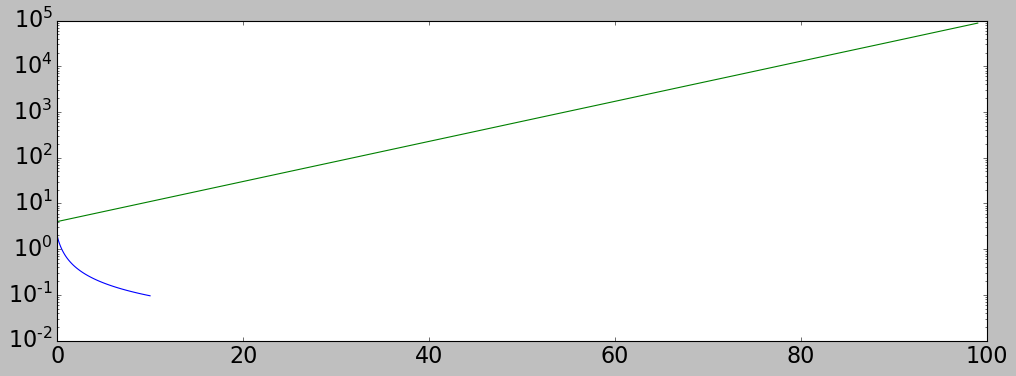

In [100]:
from scipy.integrate import solve_ivp
def exponential_decay(t, y): return -0.5 * y

def shm(t,y): 
    return [-y[0]**2,y[1]]

t_eval=np.linspace(0,10,100)
#sol = solve_ivp(exponential_decay, [0, 10], [2])
sol = solve_ivp(shm, [0, 10], [2,4],method='RK45',t_eval=t_eval)
#print(sol.t)


print(sol.y)

plt.plot(sol.t,sol.y[0],sol.y[1])
plt.yscale('log')
plt.show()

In [65]:
#m_arr,r_arr,rhoc_arr,mb_arr,yp_arr=mass_radius()
ind=190
#print('m_arr = \n',m_arr[0:ind])
#print('r_arr = \n',len(r_arr[0:ind]),r_arr[0:ind])
#print('yp_arr = \n',yp_arr[0:ind])
#np.save('./eos_tables/BLH',[m_arr[0:ind],r_arr[0:ind],rhoc_arr[0:ind],mb_arr[0:ind],yp_arr[0:ind]])
#np.savetxt(f'./eos_tables/BLH_M_R_Mb_Lam.out',np.c_[m_arr[0:ind],r_arr[0:ind],rhoc_arr[0:ind],mb_arr[0:ind],yp_arr[0:ind]],header='#Mass Radius Baryonic_Mass Lambda \n',comments=f'#Mass(in solar mass), Radius(km), BaryonicMass(solar mass), Lambda(dimensional).\n')
blh_data=np.load('./eos_tables/BLH.npy',allow_pickle=True) 
print(len(blh_data[2]))

147


In [ ]:
blq=np.load('../EOS_data/BLQ')
np.savetxt(f'../EOS_Data/BLQ_M_R_Mb_Lam.out',np.c_[m_arr[0:ind],r_arr[0:ind],rhoc_arr[0:ind],mb_arr[0:ind],yp_arr[0:ind]],header='#Mass Radius Baryonic_Mass Lambda \n',comments=f'#Mass(in solar mass), Radius(km), BaryonicMass(solar mass), Lambda(dimensional).\n')


length of mass-radius points=200 in eos=BLQ
length of mass-radius points=291 in eos=ALF2
length of mass-radius points=147 in eos=BLH


ValueError: x and y must have same first dimension, but have shapes (100,) and (147,)

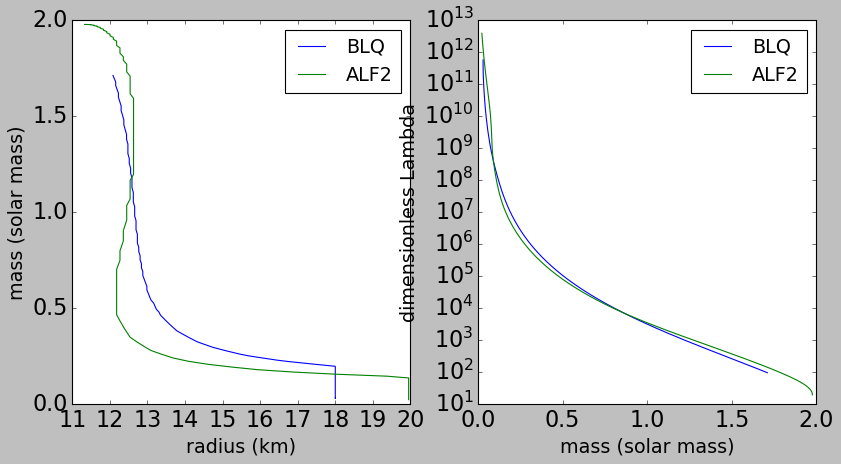

In [110]:
data_path='./m_mB_rad_data'
#data_path='../data/m_mB_rad_data'
#eos_list=['MS1','APR3','APR4','DD2','SLy','ALF2','BLQ']
eos_list=['BLQ','ALF2','BLH']

fig,((ax1,ax2))=plt.subplots(nrows=1,ncols=2,figsize=(12,6))
for eos in eos_list:
    ds=np.load(f'{data_path}/%s.npy'%eos,allow_pickle=True) #0:mass(msun), 1:radius(km), 2:rhoc(cgs), 4:lambda (in cgs)

    print(f'length of mass-radius points={len(ds[4])} in eos={eos}')
    #print(max(ds[0]))
    ax1.plot(ds[1],ds[0],label=eos)
    #ax1.plot(ds[1],ds[3],ls='--',label='mBaryonic')
    ax1.set(xlabel='radius (km)',ylabel='mass (solar mass)')
    ax1.legend()
    #plt.xlim([0.5,3.0])
    #plt.ylim([10,1.e6])
    #plt.clf()
    ax2.semilogy(ds[0],(ds[4]*const.CGS_G)*((const.CGS_C**2)/(const.CGS_G*ds[0]*const.CGS_MSUN))**5,label=eos)   #(lambda_out*const.CGS_G)*((const.CGS_C**2)/(const.CGS_G*mass_input*const.CGS_MSUN))**5
    ax2.legend()
    ax2.set(xlabel='mass (solar mass)',ylabel='dimensionless Lambda')
plt.xlabel('mass')
plt.ylabel(r'$\Lambda$')
#plt.savefig('blh_blq_mass-radius.png',dpi=150)
plt.show()

r
./matlab_Sebastiano/tov/Sequences/Complete/APR4_sequence.txt
length of mass-radius points=298 in eos=APR4
[18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.         18.         18.
 18.         18.         18.         18.       

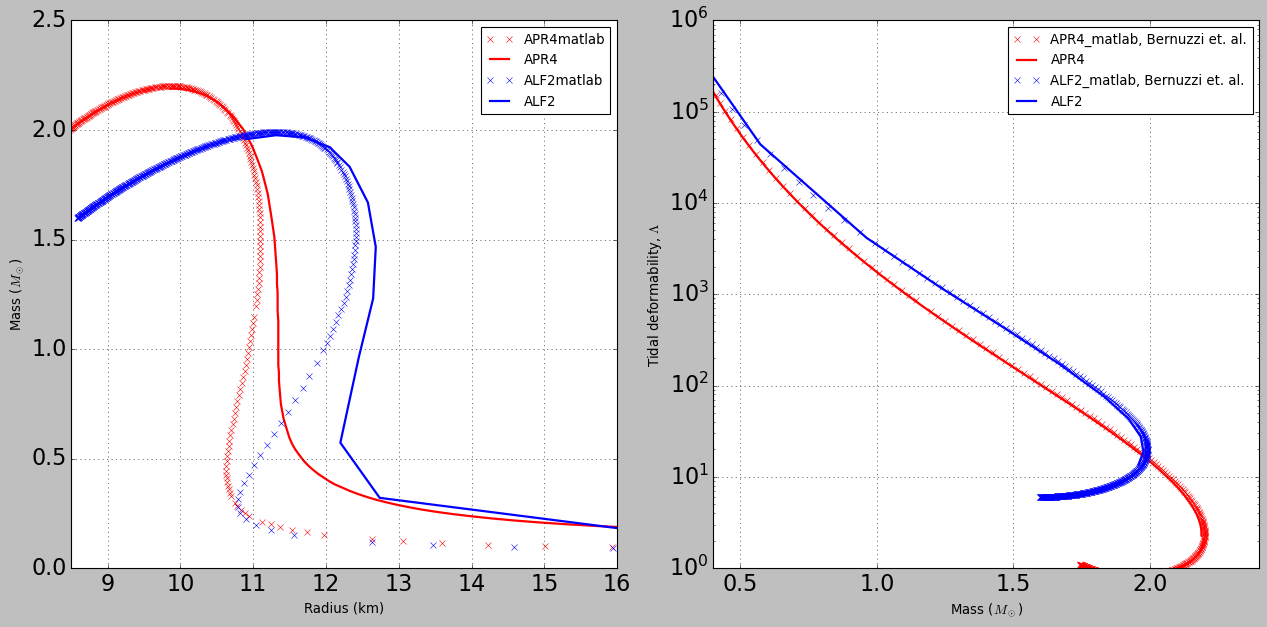

In [127]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
    
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':20,
         'ytick.labelsize':20}
pylab.rcParams.update(params)


from cycler import cycler

#eos_data_path='../../../GRMHDResearch/_kilonovae_standardization/codes/src/tov/m_mB_rad_data'

eos_data_path='./m_mB_rad_data'
#data_path='../data/m_mB_rad_data'
#eos_list=['MS1','APR4','DD2','SLy','ALF2','H4'] #'APR3',
eos_list=['APR4','ALF2'] #,'APR3']

#['BLH','BLQ','H4','MPA1','MS1','SLy','WFF1','WFF2',]

#available Matlab sequences: 'MS1','APR4','DD2','SLy','ALF2',H4

sebastiano_data='./matlab_Sebastiano/tov/Sequences/Complete/'



#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,figsize=(24,16))
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
legend_labelsize=12
xy_labelsize=12
custom_cycler = (cycler(color=['r', 'b', 'g', 'k','c','orange'])) #+ cycler(lw=[1, 2, 3, 4]))

#plt.rc('lines', linewidth=4)
#plt.rc('axes', prop_cycle=custom_cycler)

#fig.gca().set_color_cycle(['red', 'green', 'blue', 'yellow'])

#fig.suptitle('M-R relation')
for cc,eos in zip(custom_cycler,eos_list):
    print(cc['color'])
    file=sebastiano_data+eos+'_sequence.txt'  
    print(file)
    ds_matlab=np.loadtxt(file,skiprows=1)
    ax1.plot(ds_matlab[:,3]*const.AGEO_LENGTH_IN_M/1.e3,ds_matlab[:,1],'x',color=cc['color'],label=eos+'matlab')
    
    
    
    ds=np.load(f'{eos_data_path}/%s.npy'%eos) #0:mass(msun), 1:radius(km), 2:rhoc(cgs), 3: baryonic mass, 4:lambda (in cgs)
    print(f'length of mass-radius points={len(ds[4])} in eos={eos}')
    #print(max(ds[0]))
    print(ds[1])
    ax1.plot(ds[1],ds[0],color=cc['color'],lw=2,label=eos)
    #ax1.plot(ds[1],ds[3],color=cc['color'],ls='--',lw=2,label=eos+'M_Baryonic')
    
    
    m_new=np.linspace(0.5,1.9,100)
    C_arr,l_arr,r_arr=Compactness_MBaryon(m_new,eos)
    
    #ax1.plot(r_arr,m_new,'x',label='interpolated '+eos)
    ax1.set_xlabel(r'Radius (km)',fontsize=xy_labelsize)
    ax1.set_ylabel(r'Mass ($M_\odot$)',fontsize=xy_labelsize)
    ax1.set_xlim([8.5,16])
    ax1.legend(fontsize=legend_labelsize)
    ax1.grid(True)

    #ax3.plot(abs(ds[1]-r_arr)/ds[1],ds[0],'.',label=eos)
    #ax3.set(ylabel='mass',xlabel='relative interpolation error in radius')
    #ax3.set_xscale('log')
    #ax3.legend()
    
    ax2.semilogy(ds_matlab[:,1],ds_matlab[:,6],'x',color=cc['color'],label=eos+'_matlab, Bernuzzi et. al.')
    ax2.semilogy(ds[0],(ds[4]*const.CGS_G)*((const.CGS_C**2)/(const.CGS_G*ds[0]*const.CGS_MSUN))**5,color=cc['color'],lw=2,label=eos)   #(lambda_out*const.CGS_G)*((const.CGS_C**2)/(const.CGS_G*mass_input*const.CGS_MSUN))**5
    #ax2.semilogy(ds[0],ds[4],label=eos)
    #ax2.semilogy(m_new,l_arr,'x',label=f'interpolated {eos}')
    ax2.set_xlabel(r'Mass ($M_\odot$)',fontsize=xy_labelsize)
    ax2.set_ylabel(r'Tidal deformability, $\Lambda $',fontsize=xy_labelsize) #(g/cm^2/s^2)
    ax2.set_xlim([0.4,2.4])
    ax2.set_ylim([1,1.e6])
    ax2.legend(fontsize=legend_labelsize)
    ax2.grid(True)
            
    #ax3.plot(ds[0],ds[2],label=eos)
    
    #ax4.plot(ds[0],ds[3],label=eos)
ax1.set_prop_cycle(custom_cycler)
#plt.grid()
plt.tight_layout()
#plt.savefig('./data/m_mB_rad_data/plots/MR_eos.png',dpi=150)
plt.show()


['./matlab_Sebastiano/tov/Sequences/Complete/2B_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/2H_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/ALF2_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/APR4_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/BHBlp_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/BLh_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/DD2_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/ENG_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/H3_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/H4_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/HB_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/LS200_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/MPA1_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/MS1b_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/MS1_sequence.txt', './matlab_Sebastiano/tov/Sequences/Complete/SFHo_se

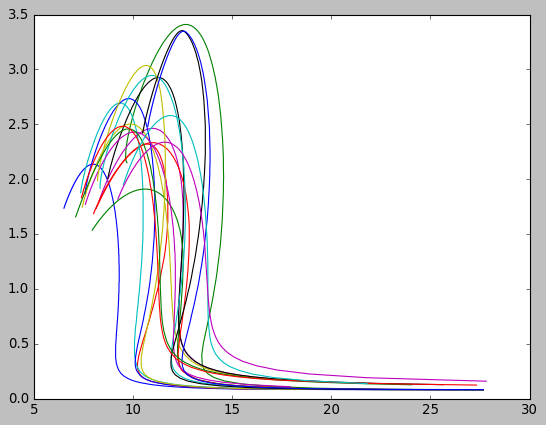

In [5]:
sebastiano_data='./matlab_Sebastiano/tov/Sequences/Complete/'
files=glob.glob(sebastiano_data+'/*txt')
print(files)

for f in files:
    eos=f.split(sebastiano_data)[1].split('.txt')[0].split('_sequence')[0]
    file=sebastiano_data+eos+'_sequence.txt'
    ds=np.loadtxt(file,skiprows=1)
    plt.plot(1.4*ds[:,3],ds[:,2],label=eos)
#plt.legend()
plt.show()